# Stack Overflow Post Moderation Using Deep NLP
Author:  
Alexander Claudino Daffara  
https://medium.com/@alexanderdaffara  
https://www.linkedin.com/in/alexanderdaffara/  

Welcome to my repo, where I combine data analysis with advanced machine learning algorithms to optimize the task of automating Stack Overflow's post Moderation.  

## Business Problem
Stack Overflow is a the Go-to programer's Q&A platform with the business goal creating a one-stop-shop for programming questions. Say you have a programming question, you can either browse the plethora of previous asked questions or make your own post. Anyone with domain experience can answer and discuss that post to recieve reputation points. Finally, all the relevant collaborative information related to that inquiry will be on that post for anyone to come.  

Unfortunately, not every question will be consistent with the platform goals and must be moderated.  

> High Quality Answers -> *Require* -> High Quality Questions -> *Require* -> High Quality Moderation

Currently, Stack Overflow outsources the moderation to members with high enough reputation points, who can vote on whether a new post should be left open for answers and discussion or should be closed for a specific reason. This can be detrimental to the users who need quick answers to their programming questions and must wait for their new post to be manually reviewed. It also relies on trusting these high reputation members to make business decisions for the platform.  

Hence, we'll employ a machine learning model to automate this process using data provided from the kaggle competition: https://www.kaggle.com/c/predict-closed-questions-on-stack-overflow .  

## Goal
 - Iterate models and Natural Language Processing techniques to accuratly classify the reason a new post will be closed

## Data Understanding
Stack Overflow's 2012 Data-Dump (21.47 GB):  

Containing 140k examples of posts, their details and their moderation results.  

The target variable "OpenStatus" has the following categories:
 - open: The post is in alignment with the platform's goals
 - not a real question: the post is ambiguous or vague, making it hard to tell what is being asked
 - off topic: the post is more suited to one of Stack Overflow's other websites in their stack exchange network, or is not a programming related questions
 - not constructive: the post is inducing debate or argumentation instead of being a constructive answer to a programming question
 - too localized: the post asks a question too specific to a country or region or softare version which will not be relevant in the near future

The provided information about the post includes:
 - The ownwer's reputation
 - age of the owner's account
 - Title of the post
 - Body Markdown of the post
 - Specified Tags related to the post (for searching)

# imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import numpy.ma as ma
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import AutoTokenizer, AutoModel
import tensorflow as tf
from torch import no_grad
from keras import Sequential, layers, regularizers
from keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical # for target labels

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (train_test_split, 
                                     RandomizedSearchCV,
                                     GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                            classification_report)
from sklearn.feature_extraction.text import (TfidfVectorizer, 
                                             CountVectorizer)
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler

import xgboost as xgb
from xgboost import XGBClassifier

import html
import re

import nltk
import nltk.tokenize
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')

import string
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preprocessing Data

### text cleaning helper functions

In [4]:
def line_start_encoder(line):
    # given an html lines, encode it's starting string
    # to identify code blocks and block quotes locaitons

    if line.startswith('<pre><code'):
        return 1
    elif line.startswith('</code'):
        return -1
    elif line.startswith('<blockquote>'):
        return 2
    elif line.startswith('</blockquote>'):
        return -2
    return 0

def clean_text_from_html_list(html_list):
    # return cleaned text from list of html lines

    # encode list to starting line codes
    no_code = pd.Series(html_list).map(line_start_encoder).to_list()

    # remove code blocks and blockquotes
    for _ in range(df.num_code_blocks.max()):
        try:
            start = no_code.index(1)
            end = no_code.index(-1, start) + 1
            no_code = no_code[:start] + no_code[end:]
            html_list = html_list[:start] + html_list[end:]
        except ValueError:
            break
    for _ in range(df.num_block_quotes.max()):
        try:
            start = no_code.index(2)
            end = no_code.index(-2, start) + 1
            no_code = no_code[:start] + no_code[end:]
            html_list = html_list[:start] + html_list[end:]
        except ValueError:
            break
    
    # add space to end sentences
    html_list = [f"{line} " for line in html_list]
    # make it one string
    html_str = "".join(html_list)

    # get only text using Beautifulsoup html parser
    text = BeautifulSoup(html_str, 'html.parser').get_text()

    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)

    # lowercase and remove trailing whitespace
    text = text.lower()
    return text.strip()

### Full preprocessing and EDA

In [18]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import re
import seaborn as sns
import markdown
import html
from bs4 import BeautifulSoup
import nltk
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')
from sklearn.preprocessing import PowerTransformer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexanderdaffara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# load data
df = pd.read_csv('data/train-sample.csv')

# drop 213 impossible reputation rows < 1
df = df.loc[df.ReputationAtPostCreation > 0]

# Create no_reputation feature indicating no recognized activity
df['no_reputation'] = df.ReputationAtPostCreation.map(
    lambda x: int(x == 1))

# create no_contributions to make distinct low activity accounts
df['no_contributions'] = (
    df['OwnerUndeletedAnswerCountAtPostTime'].map(
        lambda x: int(x==0))
)

# power transform ReputationAtPostCreation and 
# OwnerUndeletedAnswerCountAtPostTime
df['ReputationAtPostCreation'] = (
    PowerTransformer()
    .fit_transform(df[['ReputationAtPostCreation']])
)
df['OwnerUndeletedAnswerCountAtPostTime'] = (
    PowerTransformer()
    .fit_transform(df[['OwnerUndeletedAnswerCountAtPostTime']])
)

# Create account_age feature and drop negative ages and power transform
df[['PostCreationDate','OwnerCreationDate']] = (
    df[['PostCreationDate','OwnerCreationDate']]
    .apply(pd.to_datetime)
)
df['account_age'] = (
    (df['PostCreationDate'] 
     - df['OwnerCreationDate']).dt.days
)
df = df.loc[df.account_age >= 0]
df['account_age'] = (
    PowerTransformer()
    .fit_transform(df[['account_age']])
)

# Create tag text from present tags
mask = df[['Tag1','Tag2','Tag3','Tag4','Tag5']].isna()
df['tag_text'] = [
    ". ".join(row_tags.compressed()) 
    for row_tags in 
    ma.masked_array(df[['Tag1','Tag2','Tag3','Tag4','Tag5']], 
                    mask=mask)
]

# Create num_tags feature, counting how many tags are used
df['num_tags'] = (
    df[['Tag1','Tag2','Tag3','Tag4','Tag5']]
    .transpose().notna().sum()
)

# Label encode target
status_id_map = {'open':0, 
                 'not a real question':1,
                 'off topic':2,
                 'not constructive':3,
                 'too localized':4,
                 0:'open', 
                 1:'not a real question',
                 2:'off topic',
                 3:'not constructive',
                 4:'too localized'}
df['target'] = df.OpenStatus.map(status_id_map)

# create list of html lines
df['html_text'] = df.BodyMarkdown.map(
    lambda x: markdown.markdown(x).split('\n'))

# remove data with bad html parsing
df['num_bad_blocks_v2'] = df.html_text.map(
    lambda x: len([line 
                   for line in x 
                   if line.startswith('<code')]) )
df = df.loc[df.num_bad_blocks_v2 < 1]

# count num code blocks in body
df['num_code_blocks'] = df.html_text.map(
    lambda x: len([line 
                   for line in x 
                   if line.startswith('<pre><code')]) )
df['num_code_blocks_end'] = df.html_text.map(
    lambda x: len([line 
                   for line in x 
                   if line.startswith('</code')]) )
df = df.loc[(df.num_code_blocks - df.num_code_blocks_end) == 0]

# count num block quotes in body
df['num_block_quotes'] = df.html_text.map(
    lambda x: len([line 
                   for line in x 
                   if line.startswith('<blockquote')]) )
df['num_block_quotes_end'] = df.html_text.map(
    lambda x: len([line 
                   for line in x 
                   if line.startswith('</blockquote')]) )
df = df.loc[(df.num_block_quotes - df.num_block_quotes_end) == 0]

# create preprocessed text removing code blocks
df['clean_text'] = df.html_text.map(clean_text_from_html_list)

# count num links in body
df['num_links'] = df.clean_text.map(
    lambda x: len(re.findall(r'http',x)))

# Lists of sentences in body and title
df['body_sentences'] = df.clean_text.map(
    lambda x: sent_tokenize(x))
df['title_sentences'] = df.Title.map(
    lambda x: sent_tokenize(x))
# sentence counts of body and title
df['num_body_sentences'] = df.body_sentences.map(
    lambda x: len(x))
df['num_title_sentences'] = df.title_sentences.map(
    lambda x: len(x))
# word counts of body and title
df['num_body_words'] = df.clean_text.map(
    lambda x: len(word_tokenize(x)))
df['num_title_words'] = df.Title.map(
    lambda x: len(word_tokenize(x)))
# body character count
df['num_body_chars'] = df.clean_text.map(
    lambda x: len(x))

# num sentences starting with "I" in body and title
df['num_I_body_start'] = df.body_sentences.map(
    lambda x: sum(
        [sent.startswith('i ') or sent.startswith("i'") 
         for sent in x]
    )
)
df['num_I_title_start'] = df.title_sentences.map(
    lambda x: sum(
        [sent.startswith('i ') or sent.startswith("i'") 
         for sent in x])
    )
df['num_I_start'] = df.num_I_body_start + df.num_I_title_start

# num sentences starting with "you" in body and title
df['num_you_body_start'] = df.body_sentences.map(
    lambda x: sum(
        [sent.startswith('you ') or sent.startswith("you'") 
         for sent in x])
    )
df['num_you_title_start'] = df.title_sentences.map(
    lambda x: sum(
        [sent.startswith('you ') or sent.startswith("you'") 
         for sent in x])
    )
df['num_you_start'] = df.num_you_body_start + df.num_you_title_start

# combined title and body strings
df['title_body_text'] = [
    ". ".join([title,body])
    for title, body in
    zip(df.Title,df.clean_text)]

# num of interrogatory words in combined text
df['num_who'] = df.title_body_text.map(
    lambda x: len(re.findall(r'who ',x)))
df['num_what'] = df.title_body_text.map(
    lambda x: len(re.findall(r'what ',x)))
df['num_when'] = df.title_body_text.map(
    lambda x: len(re.findall(r'when ',x)))
df['num_where'] = df.title_body_text.map(
    lambda x: len(re.findall(r'where ',x)))
df['num_why'] = df.title_body_text.map(
    lambda x: len(re.findall(r'why ',x)))
df['num_whose'] = df.title_body_text.map(
    lambda x: len(re.findall(r'whose ',x)))
df['num_which'] = df.title_body_text.map(
    lambda x: len(re.findall(r'which ',x)))
df['num_how'] = df.title_body_text.map(
    lambda x: len(re.findall(r'how ',x)))

# make all numeric cols floats
for col in df.select_dtypes(int,float).columns:
    df[col] = df[col].astype(np.float32)

# create final text for embedding
df['text'] = [". ".join([tag_text,post_text]) 
    for tag_text, post_text in 
    zip(df.tag_text,df.title_body_text)]


/Users/alexanderdaffara/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


ValueError: Length of values (1) does not match length of index (139174)

## Feature inter-correlations

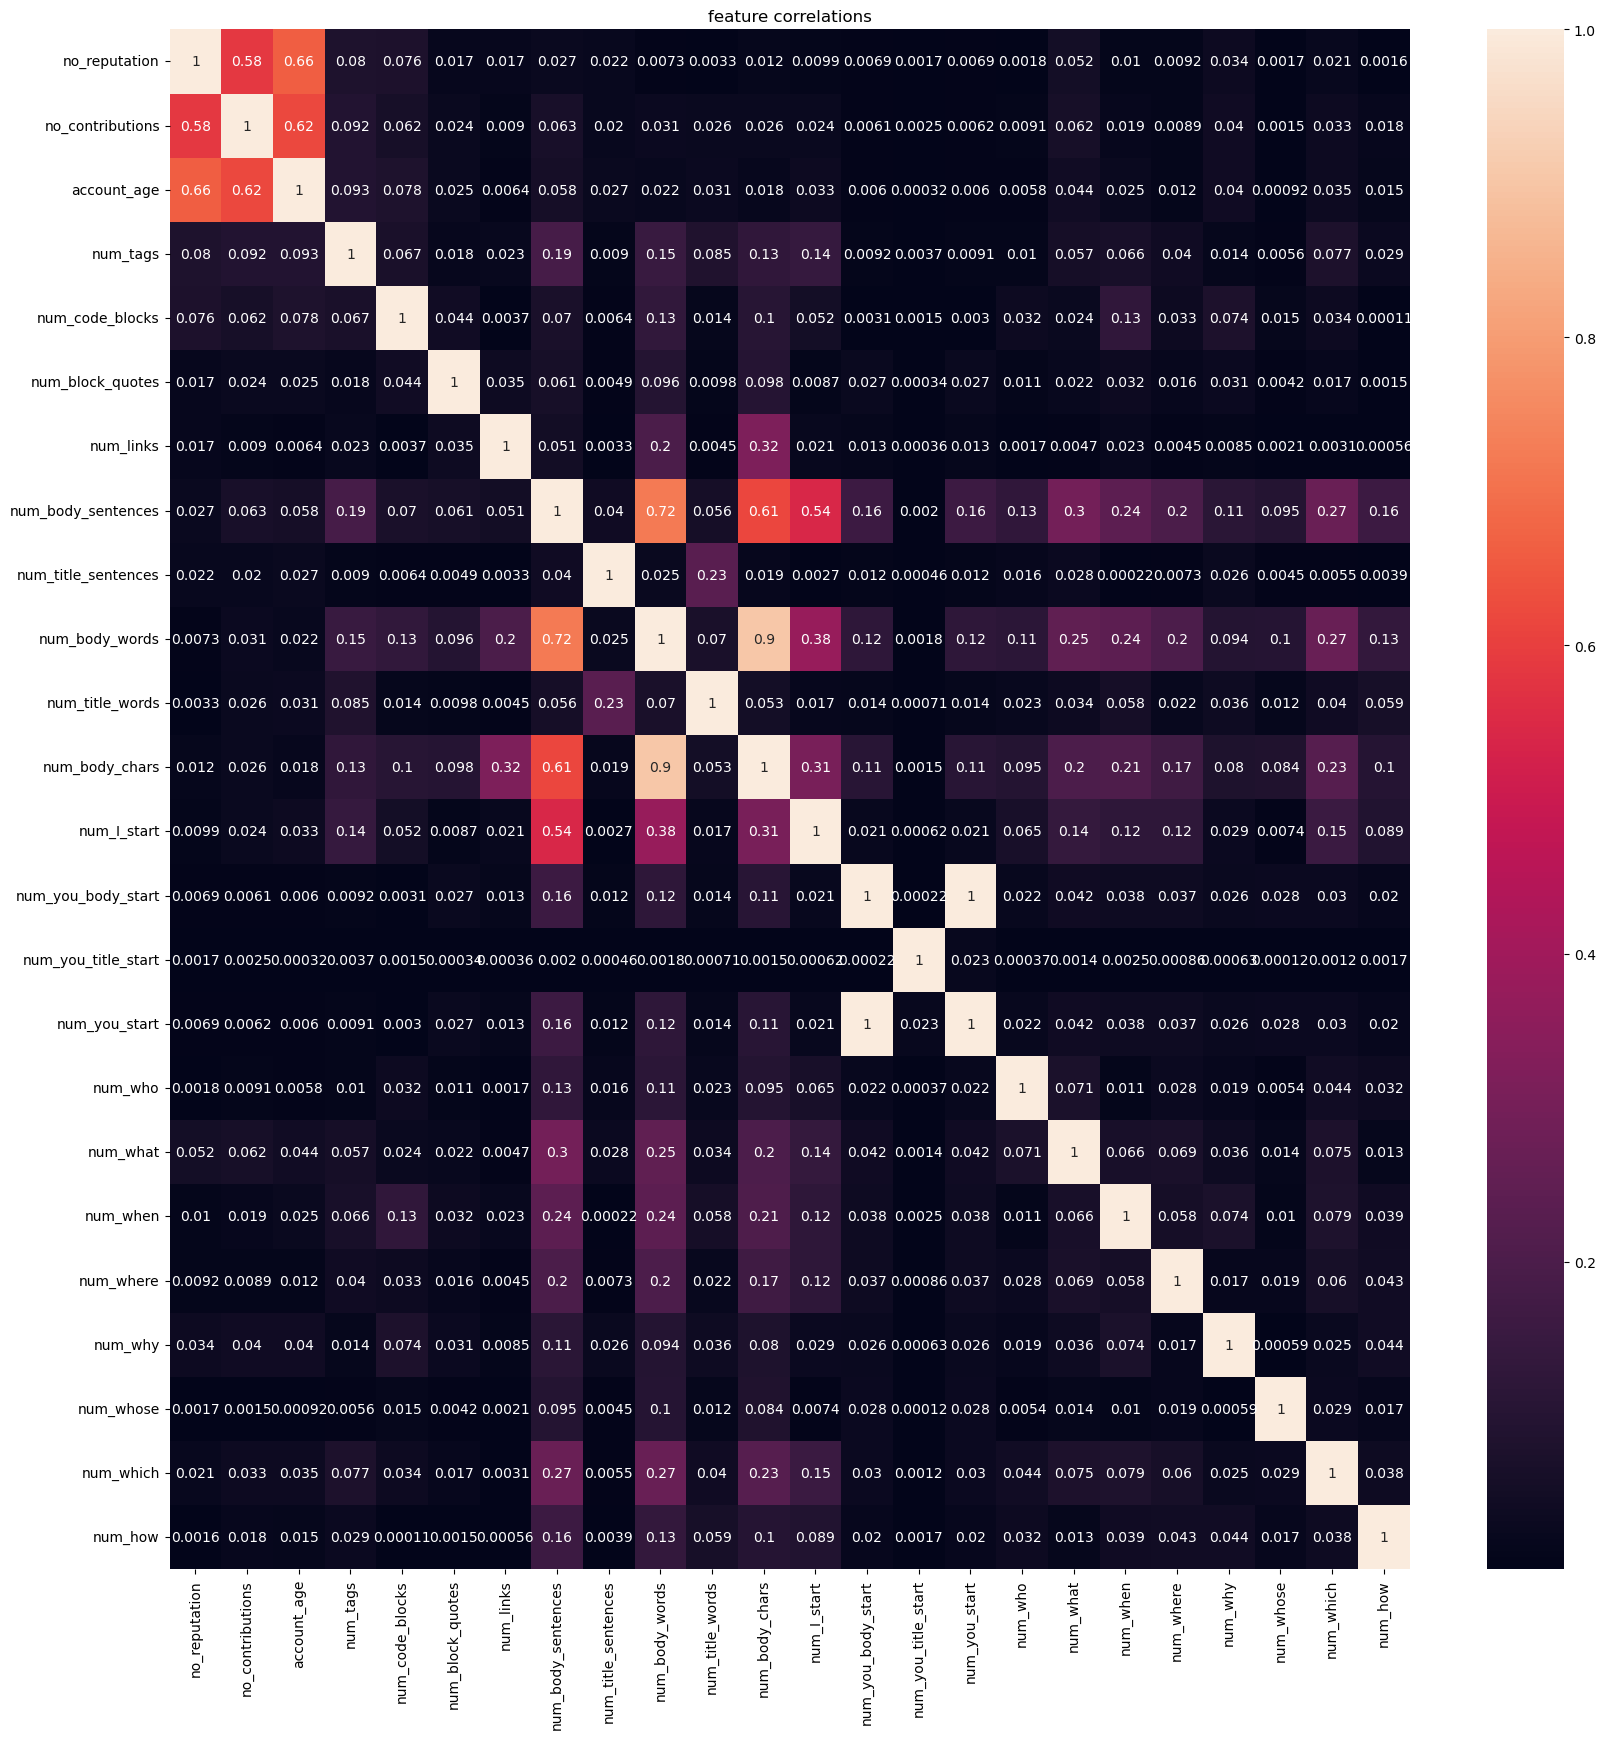

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
corr_cols = ['no_reputation', 'no_contributions',
       'account_age', 'num_tags', 'num_code_blocks',
       'num_block_quotes', 'num_links',
       'num_body_sentences',
       'num_title_sentences', 'num_body_words', 'num_title_words',
       'num_body_chars',
       'num_I_start', 'num_you_body_start', 'num_you_title_start',
       'num_you_start', 'num_who', 'num_what', 'num_when',
       'num_where', 'num_why', 'num_whose', 'num_which', 'num_how']
sns.heatmap(np.abs(df[corr_cols].astype(np.float32).corr()), 
            annot=True,
            ax=ax)
plt.title('feature correlations');

## Feature Correlations with target

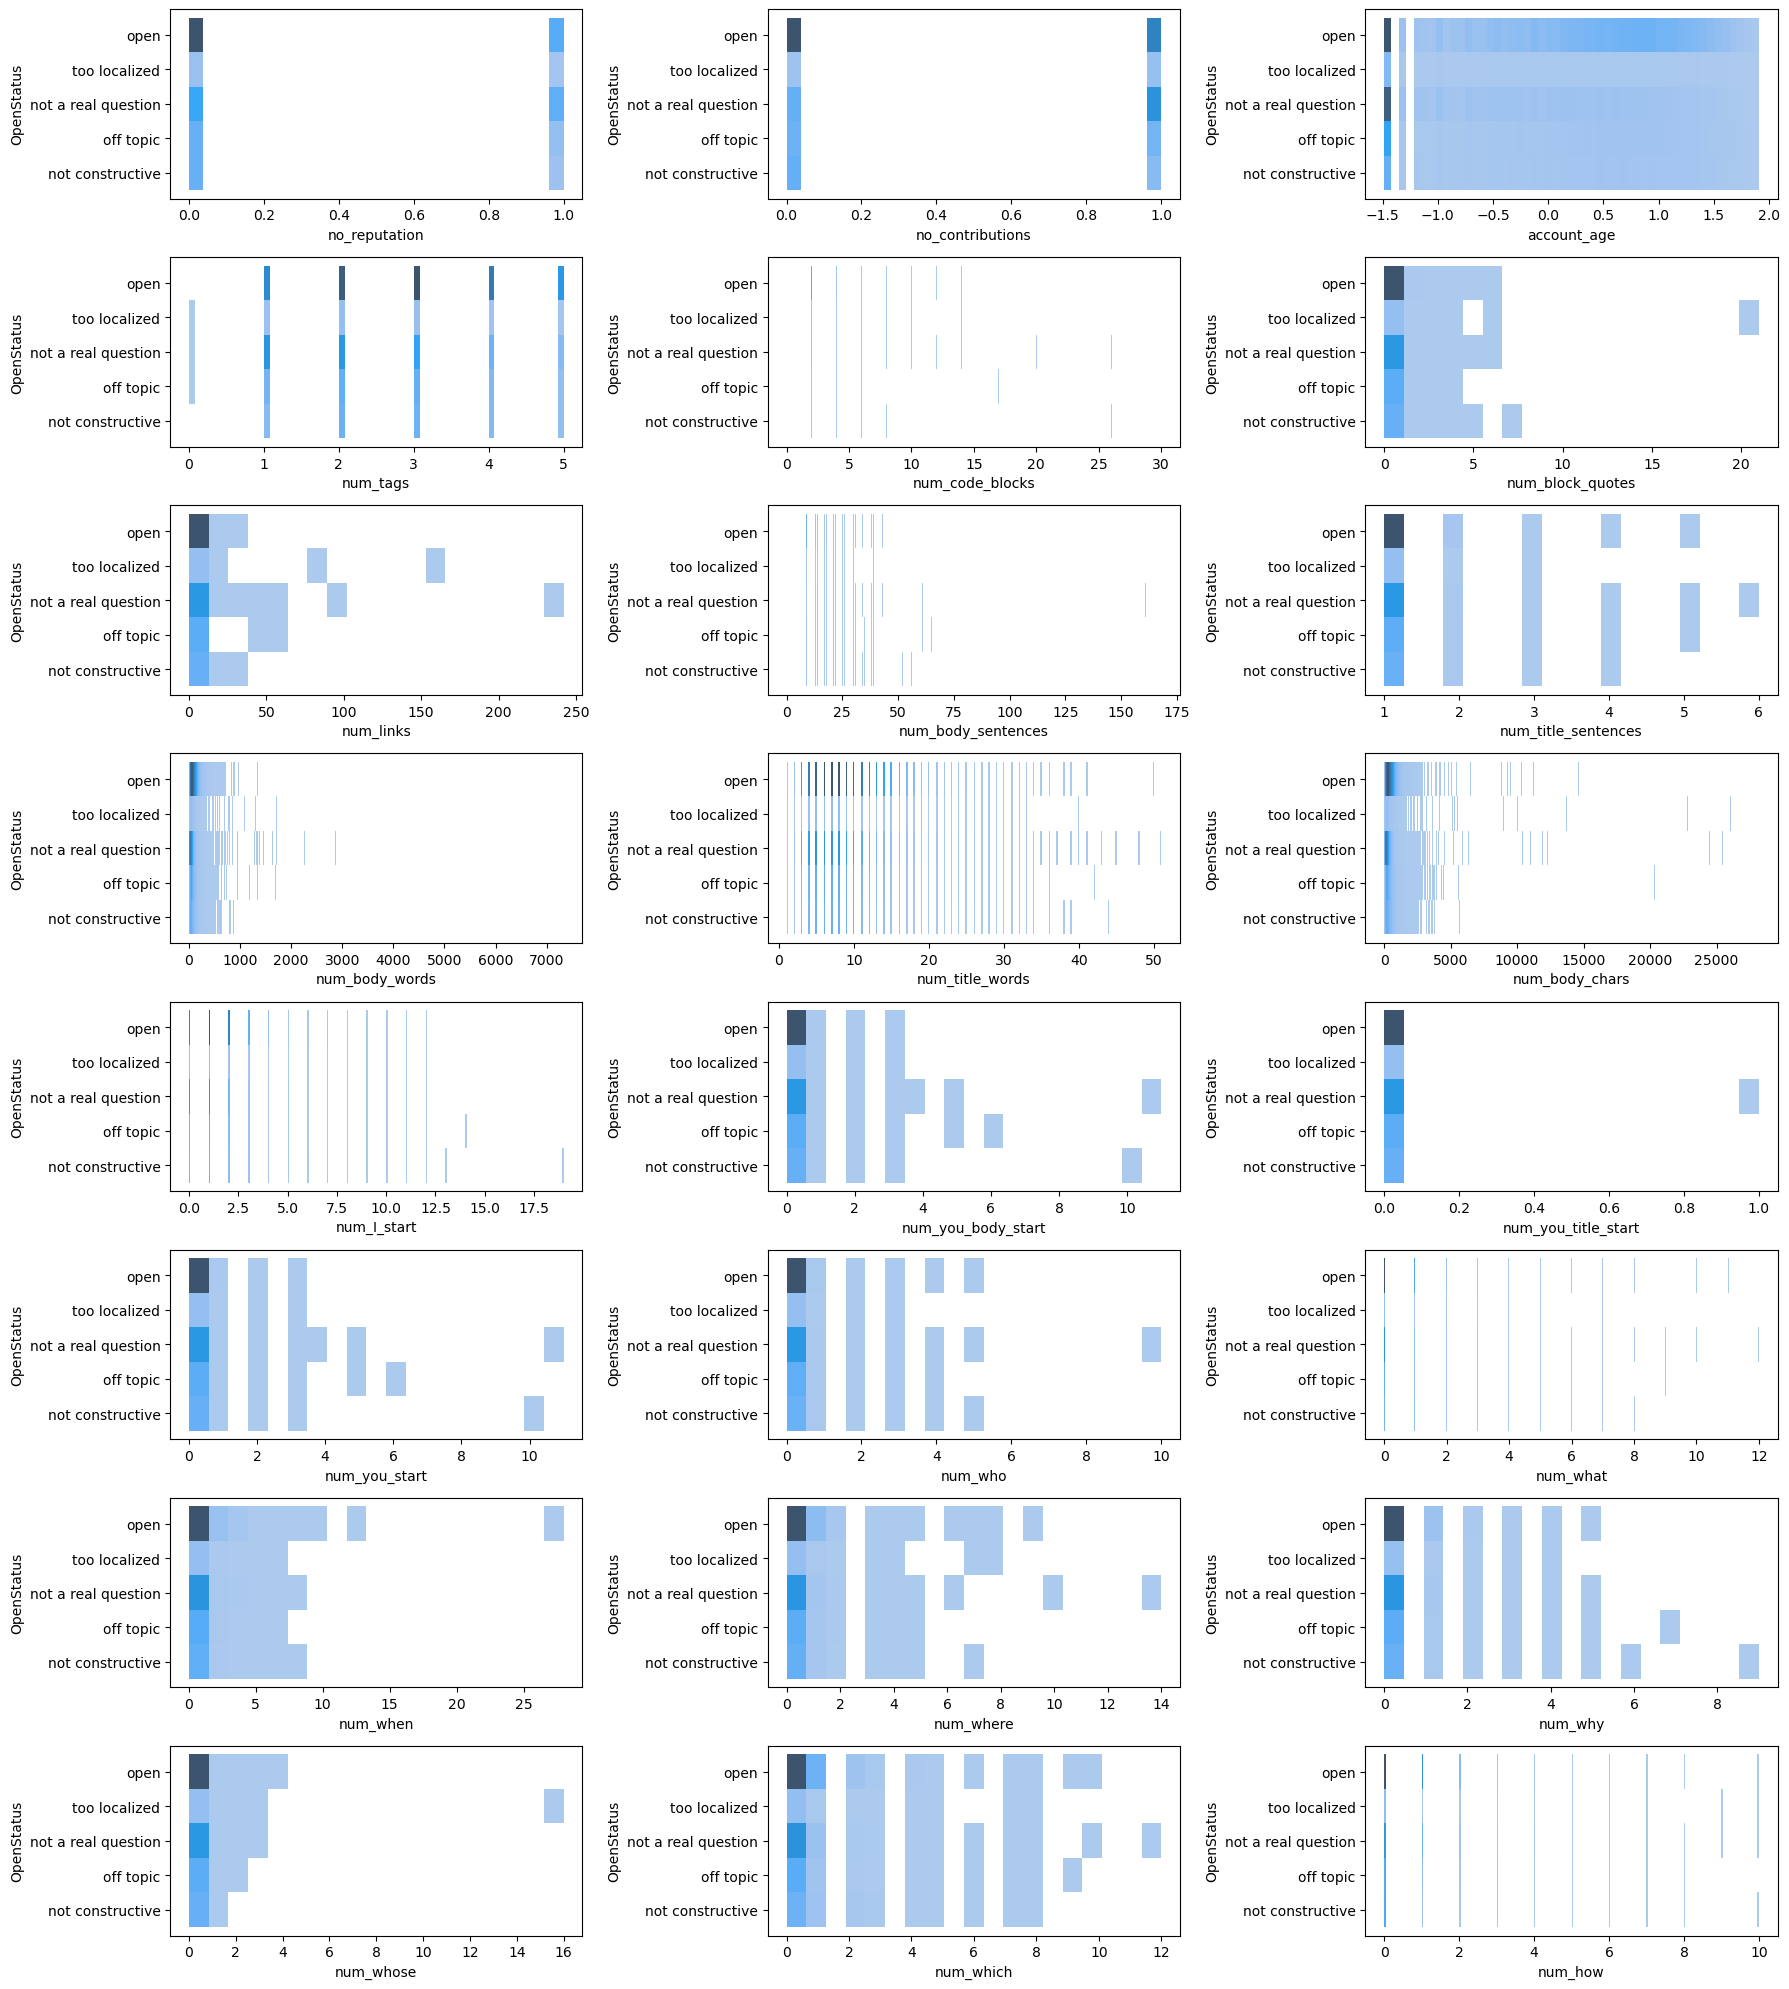

In [21]:
pairplot_cols = ['no_reputation', 
                 'no_contributions',
                 'account_age', 
                 'num_tags', 
                 'num_code_blocks',
                 'num_block_quotes', 
                 'num_links',
                 'num_body_sentences',
                 'num_title_sentences', 
                 'num_body_words', 
                 'num_title_words',
                 'num_body_chars',
                 'num_I_start', 
                 'num_you_body_start', 
                 'num_you_title_start',
                 'num_you_start', 
                 'num_who', 
                 'num_what', 
                 'num_when',
                 'num_where', 
                 'num_why', 
                 'num_whose', 
                 'num_which', 
                 'num_how']

# plot each feature against target
fig = plt.figure(figsize=(18,20))
for i, col in enumerate(pairplot_cols):
    ax = plt.subplot(8,3,i+1)
    sns.histplot(x=df[col],y=df.OpenStatus,ax=ax).set(xlabel=col)
plt.tight_layout()
plt.show()

### save pre-embedded to csv

In [ ]:
save_cols = [
    'ReputationAtPostCreation', 
    'OwnerUndeletedAnswerCountAtPostTime',
    'OpenStatus', 
    'no_reputation', 
    'no_contributions',
    'account_age',
    'num_tags',
    'num_code_blocks', 
    'num_block_quotes','num_links',
    'num_body_sentences',
    'num_title_sentences', 
    'num_body_words', 
    'num_title_words',
    'num_body_chars',
    'num_I_start',
    'num_you_start', 
    'num_who', 
    'num_what', 
    'num_when',
    'num_where', 
    'num_why',
    'num_whose', 
    'num_which', 
    'num_how', 
    'text']

df[save_cols].to_csv('data/preprocessed.csv')

## RoBERTa text Embedding

In [ ]:
# load data
df = pd.read_csv('drive/MyDrive/nlp_project/data/preprocessed.csv')

# Resulting featurespace dimention from pretrained model
embedding_magnitude = 768
display('shape before dropping long texts:',df.shape)

# initialize embedding data structure
embeddings = np.zeros((df.shape[0], embedding_magnitude))

# load pretrained RoBERTa model
tokenizer = AutoTokenizer.from_pretrained(
    "princeton-nlp/unsup-simcse-roberta-base")
model = AutoModel.from_pretrained(
    "princeton-nlp/unsup-simcse-roberta-base")

# don't calculate gradients during embeddings
with no_grad():
    for i, text in enumerate(df.text):
        # get tokens
        inputs = tokenizer(text, return_tensors="pt")

        # nan rows with too many tokens
        if inputs['input_ids'].shape[1] > 512:
            embeddings[i,:] = np.array([np.nan]*embedding_magnitude)
            continue
        out = model(**inputs)['pooler_output']
        embeddings[i,:] = np.array(out)

use_cols = ['OpenStatus',
            'ReputationAtPostCreation',
            'OwnerUndeletedAnswerCountAtPostTime',
            'account_age',
            'num_tags',
            'title_wc',
            'body_wc']
df = pd.concat(
    (df[use_cols],
     pd.DataFrame(
        embeddings,
        columns=[f"emb_{i}" for i in range(embedding_magnitude)])), 
    axis=1).dropna()
df.reset_index(drop=True, inplace=True)

# save preprocessed Dataframe with RoBERTa embeddings to csv
df.to_csv('data/preprocessed_roberta.csv')


(421316, 15)

'shape before dropping long texts:'

(420853, 21)

Token indices sequence length is longer than the specified maximum sequence length for this model (1365 > 512). Running this sequence through the model will result in indexing errors


0 / 420853
100 / 420853
200 / 420853
300 / 420853
400 / 420853
500 / 420853
600 / 420853
700 / 420853
800 / 420853
900 / 420853
1000 / 420853
1100 / 420853
1200 / 420853
1300 / 420853
1400 / 420853
1500 / 420853
1600 / 420853
1700 / 420853
1800 / 420853
1900 / 420853
2000 / 420853
2100 / 420853
2200 / 420853
2300 / 420853
2400 / 420853
2500 / 420853
2600 / 420853
2700 / 420853
2800 / 420853
2900 / 420853
3000 / 420853
3100 / 420853
3200 / 420853
3300 / 420853
3400 / 420853
3500 / 420853
3600 / 420853
3700 / 420853
3800 / 420853
3900 / 420853
4000 / 420853
4100 / 420853
4200 / 420853
4300 / 420853
4400 / 420853
4500 / 420853
4600 / 420853
4700 / 420853
4800 / 420853
4900 / 420853
5000 / 420853
5100 / 420853
5200 / 420853
5300 / 420853
5400 / 420853
5500 / 420853
5600 / 420853
5700 / 420853
5800 / 420853
5900 / 420853
6000 / 420853
6100 / 420853
6200 / 420853
6300 / 420853
6400 / 420853
6500 / 420853
6600 / 420853
6700 / 420853
6800 / 420853
6900 / 420853
7000 / 420853
7100 / 420853
7200

# Model Pipeline

## TF-IDF | Train-Val-Test split

In [2]:
# load data
df = pd.read_csv(
    'drive/MyDrive/nlp_project/data/preprocessed.csv', 
    index_col=0)

status_id_map = {'open':0, 
                 'not a real question':1,
                 'off topic':2,
                 'not constructive':3,
                 'too localized':4,
                 0:'open', 
                 1:'not a real question',
                 2:'off topic',
                 3:'not constructive',
                 4:'too localized'}
y = df.OpenStatus.map(status_id_map).astype(np.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['OpenStatus']), 
    y, 
    test_size=0.15, 
    stratify=y, 
    random_state=42
)

# Split the Train data into train and cross-val sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size = 0.2,
    stratify=y_train,
    random_state=42
)

def remove_punctuation(text):
    # Create a string of all punctuation characters
    punctuations = string.punctuation

    # Create an empty string to hold the text without punctuation
    no_punct = ""

    # Iterate through each character in the text
    for char in text:
        # If the character is not a punctuation character, 
        # add it to the no_punct string
        if char not in punctuations:
            no_punct += char

    return no_punct

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Custom preprocessor function that applies 
# tokenization and lemmatization
def tokenizer(text):
    words = nltk.word_tokenize(remove_punctuation(text))
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return [word for word in lemmatized]

# Initialize the TfidfVectorizer and transform data
vectorizer = TfidfVectorizer(
    tokenizer=tokenizer, 
    stop_words='english', 
    min_df=2, 
    max_df=.95, 
    max_features=5000)
vectorizer.fit(X_train['text'])

X_train[list(vectorizer.get_feature_names_out())] = (
    vectorizer.transform(X_train['text']).toarray())
X_val[list(vectorizer.get_feature_names_out())] = (
    vectorizer.transform(X_val['text']).toarray())
X_test[list(vectorizer.get_feature_names_out())] = (
    vectorizer.transform(X_test['text']).toarray())

scale_cols = ['account_age',
              'num_tags',
              'num_code_blocks',
              'num_block_quotes',
              'num_links',
              'num_body_sentences',
              'num_title_sentences',
              'num_body_words',
              'num_title_words',
              'num_body_chars',
              'num_I_start',
              'num_you_start',
              'num_who',
              'num_what',
              'num_when',
              'num_where',
              'num_why',
              'num_whose',
              'num_which',
              'num_how']

X_train = pd.concat(
    (X_train[scale_cols],X_train.drop(columns=scale_cols)),
    axis=1)
X_val = pd.concat(
    (X_val[scale_cols],X_val.drop(columns=scale_cols)),
    axis=1)
X_test = pd.concat(
    (X_test[scale_cols],X_test.drop(columns=scale_cols)),
    axis=1)

### Logistic Regression Tf-idf

In [8]:
# Define the preprocessing pipeline for scaling features
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), list(range(len(scale_cols))))
    ], remainder='passthrough'
)

lr_model = Pipeline(
    [('preprocessor', preprocessor), ('clf', LogisticRegression())])

lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19])])),
                ('clf', LogisticRegression())])

Eval

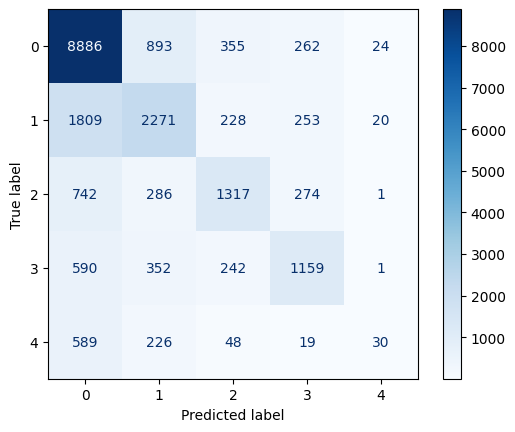

Mean Accuracy:  0.6544522680461752
Mean Precision: 0.5706951875541411
Mean Recall:    0.4757093628757552
Mean f1-score:  0.4890215354238306


,precision,recall,f1-score,support
open,0.704344,0.852783,0.771488,10420.000000
not a real question,0.563803,0.495743,0.527587,4581.000000
off topic,0.601370,0.502672,0.547609,2620.000000
not constructive,0.589222,0.494454,0.537694,2344.000000
too localized,0.394737,0.032895,0.060729,912.000000
accuracy,0.654452,0.654452,0.654452,0.654452
macro avg,0.570695,0.475709,0.489022,20877.000000
weighted avg,0.634132,0.654452,0.632575,20877.000000


In [9]:
# probability for each class
predicted = lr_model.predict(X_test)

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

target_names=[status_id_map[i] for i in range(num_classes)]
report = classification_report(y_test, 
                               predicted,
                               target_names=target_names, 
                               output_dict=True)
hxgb_metrics_df = pd.DataFrame(report).transpose()
print('Mean Accuracy: ',hxgb_metrics_df['support']['accuracy'])
print('Mean Precision:',hxgb_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',hxgb_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',hxgb_metrics_df['f1-score']['macro avg'])
hxgb_metrics_df

### Sequential tf-idf Vectorized v1
using Class_weights  
adam_learning_rate = 1e-3  
batch_size=1024, epochs=200  

In [ ]:
train_size = y_train.shape[0]
num_classes = 5
class_weight = {
    i : train_size/(num_classes*class_count) 
    for i, class_count in zip(
        y_train.value_counts().index,y_train.value_counts().values
    )
}
# Define the preprocessing pipeline for scaling features
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), list(range(len(scale_cols))))
    ], remainder='passthrough'
)


# Define the Keras sequential model
model = Sequential([
    layers.Dense(512, 
                 activation='relu', 
                 input_shape=(X_train.shape[1],)),
    layers.Dropout(.5),
    layers.Dense(256, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(0.001)),
    layers.Dropout(.3),
    layers.Dense(128, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(.001)),
    layers.Dropout(.1),
    layers.Dense(64, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(.001)),
    layers.Dropout(.1),
    layers.Dense(5, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

trainCallback = EarlyStopping(monitor='loss', 
                              min_delta = 1e-6, 
                              patience = 5)

model.summary()

history = model.fit(preprocessor.fit_transform(X_train), 
                    to_categorical(y_train), 
                    batch_size=1024, 
                    epochs=200, 
                    class_weight=class_weight,
                    callbacks=[trainCallback],
                    validation_data = (
                        preprocessor.transform(X_val), 
                        to_categorical(y_val)
                    ),
                    verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               2572800   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

Eval

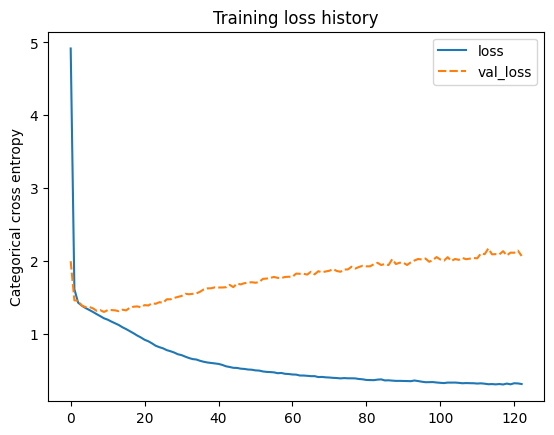

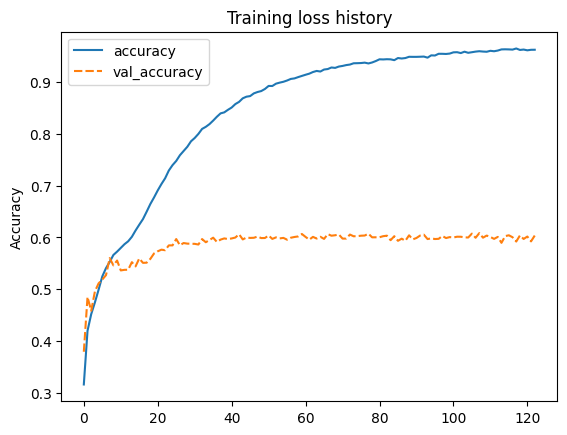

653/653 [==============================] - 2s 2ms/step


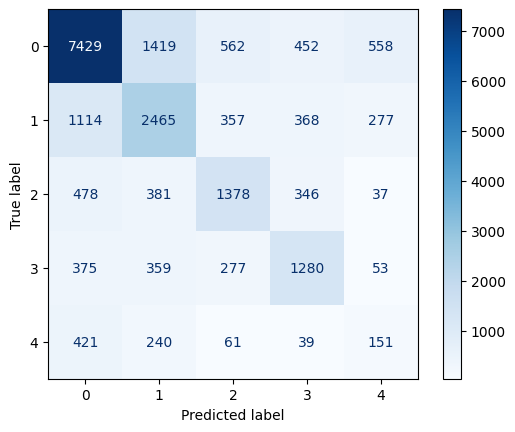

Mean Accuracy:  0.6084686497102074
Mean Precision: 0.48838366090618673
Mean Recall:    0.49772948659746535
Mean f1-score:  0.4925327723380211


,precision,recall,f1-score,support
open,0.756748,0.712956,0.734200,10420.000000
not a real question,0.506785,0.538092,0.521969,4581.000000
off topic,0.522960,0.525954,0.524453,2620.000000
not constructive,0.515091,0.546075,0.530130,2344.000000
too localized,0.140335,0.165570,0.151911,912.000000
accuracy,0.608469,0.608469,0.608469,0.608469
macro avg,0.488384,0.497729,0.492533,20877.000000
weighted avg,0.618499,0.608469,0.612959,20877.000000


In [ ]:
history_df = pd.DataFrame(history.history)
col_list = ['loss', 'val_loss']
sns.lineplot(history_df[col_list])
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

col_list = ['accuracy', 'val_accuracy']
sns.lineplot(history_df[col_list])
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

# probability for each class
y_proba = model.predict(preprocessor.transform(X_test))
predicted = np.argmax(y_proba, axis=-1)

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

target_names=[status_id_map[i] for i in range(num_classes)]
report = classification_report(y_test, 
                               predicted,
                               target_names=target_names, 
                               output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
print('Mean Accuracy: ',metrics_df['support']['accuracy'])
print('Mean Precision:',metrics_df['precision']['macro avg'])
print('Mean Recall:   ',metrics_df['recall']['macro avg'])
print('Mean f1-score: ',metrics_df['f1-score']['macro avg'])
metrics_df

### Sequential tf-idf Vectorized v2
More Dropout, Less l1 Regularization
Balanced Class_weights  
adam_learning_rate = 1e-3  
batch_size=1024, epochs=300  

In [ ]:
train_size = y_train.shape[0]
num_classes = 5
class_weight = {
    i : train_size/(num_classes*class_count) 
    for i, class_count in zip(
        y_train.value_counts().index,y_train.value_counts().values
    )
}
# Define the preprocessing pipeline for scaling features
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), list(range(len(scale_cols))))
    ], remainder='passthrough'
)


# Define the Keras sequential model
model = Sequential([
    layers.Dense(512, 
                 activation='relu', 
                 input_shape=(X_train.shape[1],)),
    layers.Dropout(.6),
    layers.Dense(256, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(0.0001)),
    layers.Dropout(.5),
    layers.Dense(128, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(.0001)),
    layers.Dropout(.5),
    layers.Dense(64, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(.0001)),
    layers.Dropout(.1),
    layers.Dense(5, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

trainCallback = EarlyStopping(monitor='loss', 
                              min_delta = 1e-6, 
                              patience = 5)

model.summary()

history = model.fit(preprocessor.fit_transform(X_train), 
                    to_categorical(y_train), 
                    batch_size=1024, 
                    epochs=300, 
                    class_weight=class_weight,
                    callbacks=[trainCallback],
                    validation_data = (
                        preprocessor.transform(X_val), 
                        to_categorical(y_val)
                    ),
                    verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               2572800   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

Eval

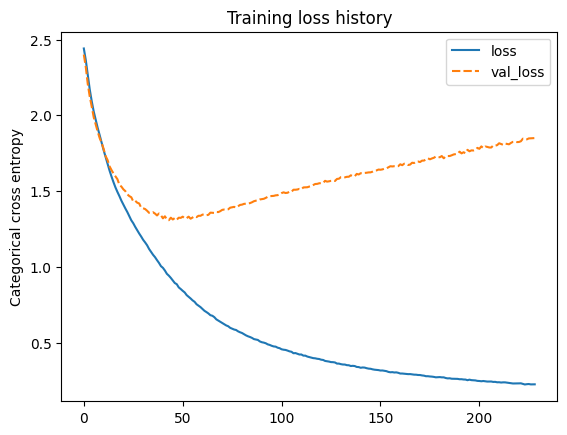

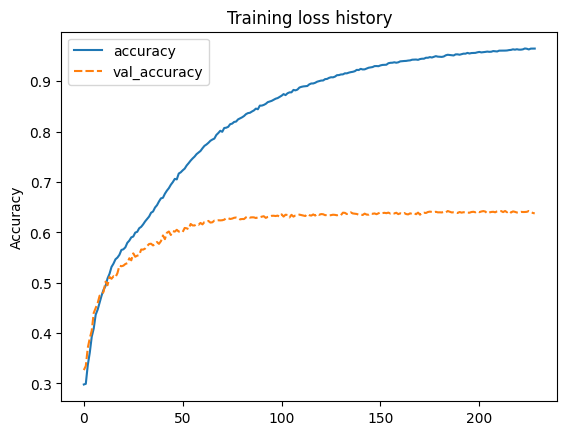

653/653 [==============================] - 2s 2ms/step


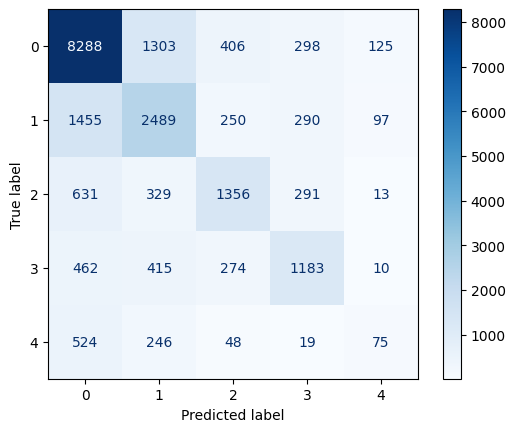

Mean Accuracy:  0.6414235761843177
Mean Precision: 0.5267799079591731
Mean Recall:    0.4886423102540598
Mean f1-score:  0.4993222650841024


,precision,recall,f1-score,support
open,0.729577,0.795393,0.761065,10420.000000
not a real question,0.520494,0.543331,0.531667,4581.000000
off topic,0.580977,0.517557,0.547436,2620.000000
not constructive,0.568477,0.504693,0.534689,2344.000000
too localized,0.234375,0.082237,0.121753,912.000000
accuracy,0.641424,0.641424,0.641424,0.641424
macro avg,0.526780,0.488642,0.499322,20877.000000
weighted avg,0.625329,0.641424,0.630574,20877.000000


In [ ]:
history_df = pd.DataFrame(history.history)
col_list = ['loss', 'val_loss']
sns.lineplot(history_df[col_list])
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

col_list = ['accuracy', 'val_accuracy']
sns.lineplot(history_df[col_list])
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

# probability for each class
y_proba = model.predict(preprocessor.transform(X_test))
predicted = np.argmax(y_proba, axis=-1)

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

target_names=[status_id_map[i] for i in range(num_classes)]
report = classification_report(y_test, 
                               predicted,
                               target_names=target_names, 
                               output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
print('Mean Accuracy: ',metrics_df['support']['accuracy'])
print('Mean Precision:',metrics_df['precision']['macro avg'])
print('Mean Recall:   ',metrics_df['recall']['macro avg'])
print('Mean f1-score: ',metrics_df['f1-score']['macro avg'])
metrics_df

### XGBoost Tf-Idf

In [3]:
# Define the preprocessing pipeline with XGBClassifier
preprocessor = ColumnTransformer(
    [('scaler', StandardScaler(), scale_cols)], 
    remainder='passthrough'
)
hgb_pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', XGBClassifier(
        tree_method='gpu_hist',
        max_bin=64,
        predictor='gpu_predictor',
        colsample_bytree=.9,
        max_depth=8,
        n_estimators=300,
        subsample=1,
        random_state=42
        )
    )
])
hgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['account_age', 'num_tags',
                                                   'num_code_blocks',
                                                   'num_block_quotes',
                                                   'num_links',
                                                   'num_body_sentences',
                                                   'num_title_sentences',
                                                   'num_body_words',
                                                   'num_title_words',
                                                   'num_body_chars',
                                                   'num_I_start',
                                                   'num_you_start', 'num_who',
                                                   'num_what', 'num_when',
                                                   'nu...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=64, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob',
                               predictor='gpu_predictor', ...))])

Eval

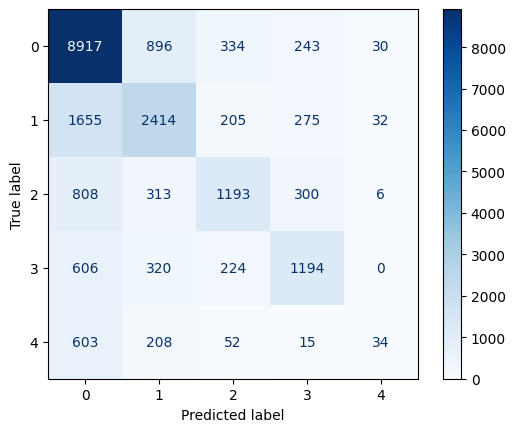

Mean Accuracy:  0.6587153326627389
Mean Precision: 0.5612736186097287
Mean Recall:    0.47694544306838493
Mean f1-score:  0.49138870833595527


,precision,recall,f1-score,support
open,0.708317,0.855758,0.775088,10420.000000
not a real question,0.581547,0.526959,0.552909,4581.000000
off topic,0.594124,0.455344,0.515557,2620.000000
not constructive,0.589048,0.509386,0.546328,2344.000000
too localized,0.333333,0.037281,0.067061,912.000000
accuracy,0.658715,0.658715,0.658715,0.658715
macro avg,0.561274,0.476945,0.491389,20877.000000
weighted avg,0.636397,0.658715,0.637151,20877.000000


In [5]:
# calculate predicitons
predicted = hgb_pipe.predict(X_test)

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

target_names=[status_id_map[i] for i in range(5)]
report = classification_report(y_test, 
                               predicted,
                               target_names=target_names, 
                               output_dict=True)
hxgb_metrics_df = pd.DataFrame(report).transpose()
print('Mean Accuracy: ',hxgb_metrics_df['support']['accuracy'])
print('Mean Precision:',hxgb_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',hxgb_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',hxgb_metrics_df['f1-score']['macro avg'])
hxgb_metrics_df

## RoBERTa | Train-Test split

In [ ]:
# load roberta Dataframe
df = pd.read_csv('data/preprocessed_roberta.csv', index_col=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['OpenStatus']), 
    df.OpenStatus, 
    stratefy=df.OpenStatus,
    test_size=0.2, 
    random_state=42
)

### XGBoost RoBERTa

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['OpenStatus']), 
    df.OpenStatus, 
    test_size=0.2, 
    random_state=42
)

# Define the preprocessing pipeline with XGBClassifier
preprocessor = ColumnTransformer(
    [('scaler', StandardScaler(), scale_cols)], 
    remainder='passthrough'
)
hgb_pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', XGBClassifier(
        tree_method='gpu_hist',
        max_bin=64,
        predictor='gpu_predictor',
        colsample_bytree=.9,
        max_depth=8,
        n_estimators=300,
        subsample=1,
        random_state=42
        )
    )
])
hgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [0, 1, 2])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, ga...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=64, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob',
                               predictor='gpu_predictor', ...))])

Eval

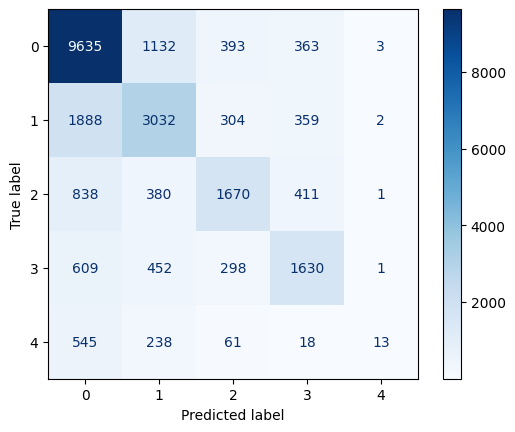

Mean Accuracy:  0.6582633053221288
Mean Precision: 0.6281880330455019
Mean Recall:    0.48897742330697813
Mean f1-score:  0.49564838935639877


,precision,recall,f1-score,support
open,0.712912,0.835936,0.769538,11526.000000
not a real question,0.579289,0.542883,0.560495,5585.000000
off topic,0.612619,0.506061,0.554265,3300.000000
not constructive,0.586120,0.545151,0.564893,2990.000000
too localized,0.650000,0.014857,0.029050,875.000000
accuracy,0.658263,0.658263,0.658263,0.658263
macro avg,0.628188,0.488977,0.495648,24276.000000
weighted avg,0.650653,0.658263,0.640286,24276.000000


In [ ]:
# probability for each class
predicted = hgb_pipe.predict(X_test)

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

target_names = [status_id_map[i] for i in range(num_classes)]
report = classification_report(y_test, 
                               predicted,
                               target_names=target_names, 
                               output_dict=True)
hxgb_metrics_df = pd.DataFrame(report).transpose()
print('Mean Accuracy: ',hxgb_metrics_df['support']['accuracy'])
print('Mean Precision:',hxgb_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',hxgb_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',hxgb_metrics_df['f1-score']['macro avg'])
hxgb_metrics_df

### Sequential Adam
using Class_weights  
adam_learning_rate = 1e-3  
batch_size=1024, epochs=100  

In [ ]:
train_size = y_train.shape[0]
num_classes = 5
class_weight = {
    i : train_size/(num_classes*class_count) 
    for i, class_count in zip(
        y_train.value_counts().index,y_train.value_counts().values
    )
}

y_train = to_categorical(y_train)

scale_cols = [0,1,2] # ['num_tags', 'title_wc','body_wc']


# Keras Model
class KerasTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model, batch_size=1024, epochs=100):
        self.model = model
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y=None):
        trainCallback = EarlyStopping(monitor='loss', 
                                      min_delta = 1e-6, 
                                      patience = 5)
        self.model.fit(X, 
                       y, 
                       batch_size=self.batch_size, 
                       epochs=self.epochs, 
                       class_weight=class_weight,
                       callbacks=[trainCallback],
                       validation_split = 0.2,
                       verbose=2)
        return self

    def transform(self, X):
        return self.model.predict(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def predict(self, X):
        return self.model.predict(X)

# Define the Keras sequential model
model = Sequential([
    layers.Dense(512, activation='relu', input_shape=(776,))
    layers.Dense(256, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(0.001)),
    layers.Dropout(.3),
    layers.Dense(128, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(.001)),
    layers.Dropout(.3),
    layers.Dense(64, 
                 activation='relu', 
                 kernel_regularizer=regularizers.l1(.001)),
    layers.Dropout(.3),
    layers.Dense(5, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define the preprocessing pipeline with KerasTransformer
preprocessor = ColumnTransformer(
    [('scaler', StandardScaler(), scale_cols)], 
    remainder='passthrough'
)
pipeline_model = Pipeline(
    [('preprocessor', preprocessor), 
     ('model', KerasTransformer(model))]
)

model.summary()
# Fit the pipeline and model to the training data
pipeline_model.fit(X_train, y_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               397824    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [0, 1, 2])])),
                ('model',
                 KerasTransformer(model=<keras.engine.sequential.Sequential object at 0x7f2f2e205bb0>))])

Eval

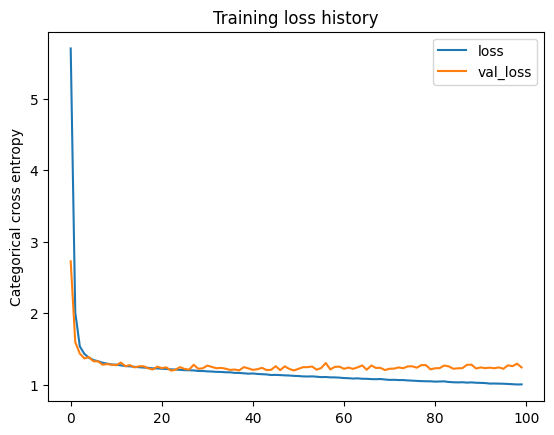

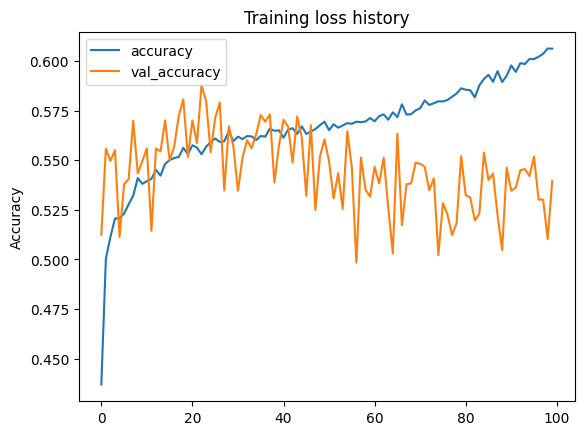

759/759 [==============================] - 1s 1ms/step


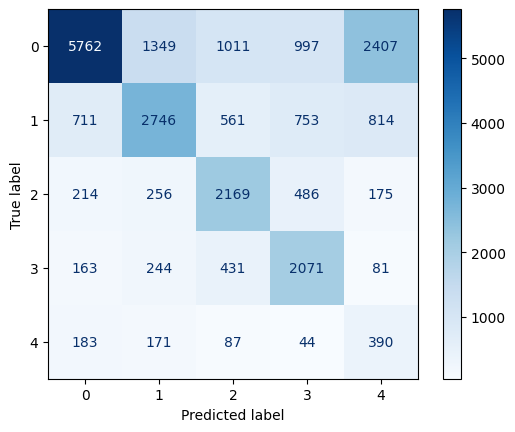

Mean Accuracy:  0.5411929477673423
Mean Precision: 0.49631108363816434
Mean Recall:    0.5574433040427215
Mean f1-score:  0.4908233366743479


,precision,recall,f1-score,support
open,0.819281,0.499913,0.620939,11526.000000
not a real question,0.576164,0.491674,0.530577,5585.000000
off topic,0.509274,0.657273,0.573885,3300.000000
not constructive,0.475983,0.692642,0.564228,2990.000000
too localized,0.100853,0.445714,0.164488,875.000000
accuracy,0.541193,0.541193,0.541193,0.541193
macro avg,0.496311,0.557443,0.490823,24276.000000
weighted avg,0.653030,0.541193,0.570316,24276.000000


In [ ]:
history = pd.DataFrame(pipeline_model['model'].model.history.history)
col_list = ['loss', 'val_loss']
history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

col_list = ['accuracy', 'val_accuracy']
history[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

# probability for each class
y_proba = pipeline_model.predict(X_test)
predicted = np.argmax(y_proba, axis=-1)

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

target_names=[status_id_map[i] for i in range(num_classes)]
report = classification_report(y_test, 
                               predicted,
                               target_names=target_names, 
                               output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
print('Mean Accuracy: ',metrics_df['support']['accuracy'])
print('Mean Precision:',metrics_df['precision']['macro avg'])
print('Mean Recall:   ',metrics_df['recall']['macro avg'])
print('Mean f1-score: ',metrics_df['f1-score']['macro avg'])
metrics_df

## Random Over-Sampling RoBERTa Data

In [ ]:
# define sampler
oversampler = RandomOverSampler(sampling_strategy='minority')
# resample train data
X_train, y_train = oversampler.fit_resample(
    preprocessor.fit_transform(X_train), y_train)
# show target distribution
pd.DataFrame(y_train).value_counts()

OpenStatus
0.0           45712
4.0           45712
1.0           22455
2.0           13333
3.0           12078
dtype: int64

### XGBoost RoBERTa Over-Sampled

In [ ]:
# Define the preprocessing pipeline with XGBClassifier
preprocessor = ColumnTransformer(
    [('scaler', StandardScaler(), scale_cols)], 
    remainder='passthrough'
)
hgb_pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', XGBClassifier(
        tree_method='gpu_hist',
        max_bin=64,
        predictor='gpu_predictor',
        colsample_bytree=.9,
        max_depth=8,
        n_estimators=300,
        subsample=1,
        random_state=42
        )
    )
])
hgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [0, 1, 2])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, ga...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=64, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob',
                               predictor='gpu_predictor', ...))])

Eval

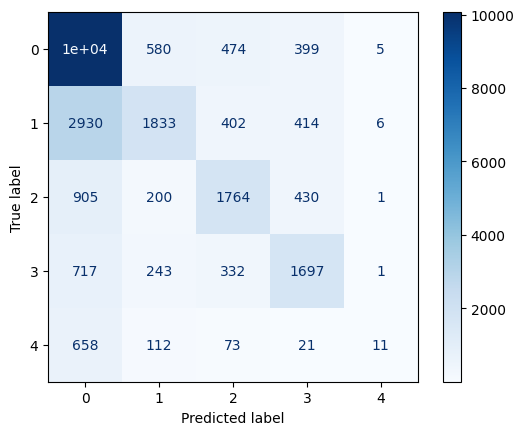

Mean Accuracy:  0.6332591860273521
Mean Precision: 0.5774670495503373
Mean Recall:    0.46327586647048247
Mean f1-score:  0.4661354030034219


,precision,recall,f1-score,support
open,0.658987,0.873503,0.751231,11526.000000
not a real question,0.617588,0.328201,0.428622,5585.000000
off topic,0.579310,0.534545,0.556028,3300.000000
not constructive,0.573117,0.567559,0.570324,2990.000000
too localized,0.458333,0.012571,0.024472,875.000000
accuracy,0.633259,0.633259,0.633259,0.633259
macro avg,0.577467,0.463276,0.466135,24276.000000
weighted avg,0.620823,0.633259,0.601999,24276.000000


In [ ]:
# predicitons
predicted = hgb_pipe.predict(X_test)

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

target_names=[status_id_map[i] for i in range(num_classes)]
report = classification_report(y_test, 
                               predicted,
                               target_names=target_names, 
                               output_dict=True)
hxgb_metrics_df = pd.DataFrame(report).transpose()
print('Mean Accuracy: ',hxgb_metrics_df['support']['accuracy'])
print('Mean Precision:',hxgb_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',hxgb_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',hxgb_metrics_df['f1-score']['macro avg'])
hxgb_metrics_df

# Conclusions  
Unfortunately the models did not perform fantastically, with the best models performing at around 65% classification accuracy.  

Although with these results I would recommend using the model with the best weighted average f1-score to prioritize which new posts should recieve moderation attention. Those with the highest probability to be closed, as predicted by the model should be moderated first.  

Hence our Final Model would be the Histogram XGBoost with RoBERTa embeddings, performing with a whopping 64% weighted average f1-score, which is far better than randomly guessing.

# Future Improvements  
In the future I would like to attempt extracting more meaning from the text, using different kinds of pretrained text embeddings and extracting more features from the text.  
  
I would also like to try training with the full 3.4M post dataset, having more time to preprocess all that data.

Kaggle Competition Link:
https://www.kaggle.com/c/predict-closed-questions-on-stack-overflow